# Adding topography to geological models
***
This chapter shows how to make geological models look more realistic by incorporating topography data:
The data can either be stored in a raster file that can be conveniently loaded into gempy.
For demonstration purposes GemPy also provides a tool to create a random hilly landscape to limit the models on the surface.

***

In [1]:
import sys
sys.path.append("../..")

import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. The common procedure to set up a model:

In [2]:
geo_model = gp.create_model('Single_layer_topo')

gp.init_data(geo_model, extent=[440720, 441129, 69280,69689,-200,250],resolution = (50,50,50),
                         path_i = os.pardir+"/data/input_data/tut-ch1-7/onelayer_interfaces.csv",
                         path_o = os.pardir+"/data/input_data/tut-ch1-7/onelayer_orient.csv")

Single_layer_topo  2019-05-03 15:39

In [3]:
# use happy spring colors! 
geo_model.surfaces.colors.change_colors({'layer1':'#ff8000','basement':'#88cc60'})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,Default series,1,False,#ff8000,1
1,basement,Basement,1,True,#88cc60,2


In [4]:
%matplotlib inline
gp.map_series_to_surfaces(geo_model, {'series':('layer1','basement')})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,series,1,False,#ff8000,1
1,basement,series,2,True,#88cc60,2


### 2. Adding topography

#### 2 a. Load from raster file

In [5]:
fp = os.pardir+"/data/input_data/tut-ch1-7/bogota.tif"

[440720 471440  69280 100000] [512 512]
Cropped raster to geo_model.grid.extent.
[440720 441129  69280  69689] [7 7]
storing converted file...


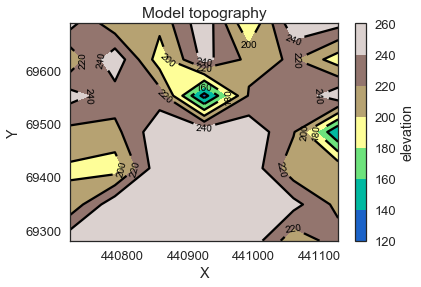

In [6]:
geo_model.set_topography(source='gdal',filepath=fp)

#### 2 b. create fun topography

If there is no topography file, but you think that your model with topography would look significantly cooler, you can use gempys function to generate a random topography based on a fractal grid:

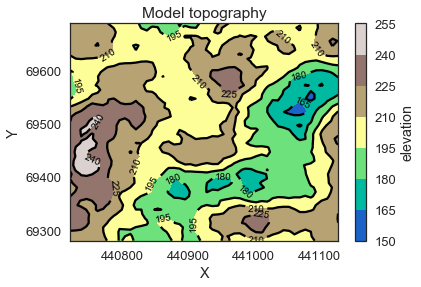

In [7]:
geo_model.set_topography(source='random')

It has additional keywords to play around with:
- fd: fractal dimension, defaults to 2.0. The higher (try 2.9), the rougher the landscape will be.
- d_z: height difference. If none, last 20% of the model in z direction.
- extent: extent in xy direction. If none, geo_model.grid.extent
- resolution: resolution of the topography array. If none, geo_model.grid.resoution. Increasing the resolution leads to much nicer geological maps!

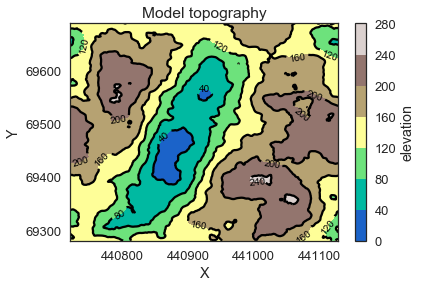

In [8]:
geo_model.set_topography(source='random',fd=1.9, d_z=np.array([0,250]), resolution=np.array([200,200]))

Note that each time this function is called, a new random topography is created. If you particularly like the generated topography or if you have loaded a large file with gdal, you can save the topography object and load it again later:

In [9]:
#save
geo_model.grid.topography.save('test_topo')

saved


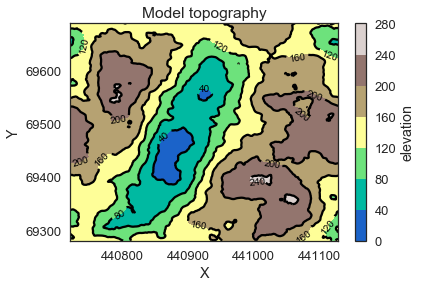

In [10]:
#load
geo_model.set_topography(source='npy',filepath='test_topo.npy')

### Compute model

In [11]:
gp.set_interpolation_data(geo_model,
                          output='geology', compile_theano=True,
                          theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


In [12]:
gp.compute_model(geo_model, compute_mesh=False, set_solutions=True)


Lithology ids 
  [ 2.  2.  2. ...,  1.  1.  1.] 

#### Visualize:
Now, the solutions object does also contain the computed geological map. It can be visualized using the plot_map function:

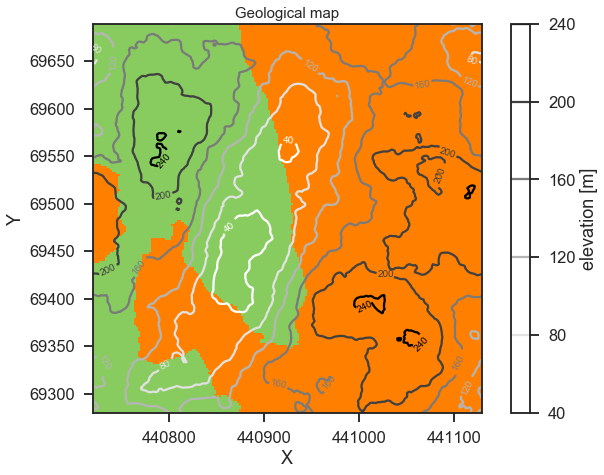

In [13]:
gp.plot.plot_map(geo_model,contour_lines=True)

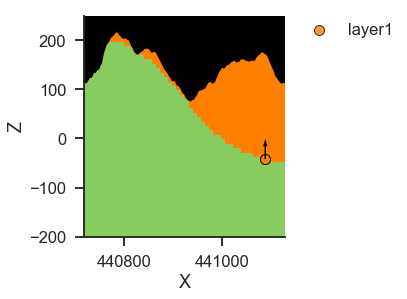

In [14]:
gp.plot.plot_section(geo_model, cell_number=42, block=geo_model.solutions.lith_block,
                         direction='y', show_data=True,show_faults=False)